## Mini-Project 3:  Computer Vision using GPU and Transfer Learning


#### CSC 180 Intelligent Systems (Fall 2020)

#### Dr. Haiquan Chen, California State University, Sacramento

In [ ]:
# Insert your name, your id, course title, assignment id, and due date here as comment 
#CSC 180 Section 1 Project 3
#Joaquin Lopez StudentID: 219471877
#Tien Dong StudentID: 219247250
#Amanda Caro StudentID: 216280897
#Due October 30, 2020




## Helpful Functions for Tensorflow (Little Gems)

The following functions will be used with TensorFlow to help preprocess the data.  They allow you to build the feature vector for a neural network. 

* Predictors/Inputs 
    * Fill any missing inputs with the median for that column.  Use **missing_median**.
    * Encode textual/categorical values with **encode_text_dummy**.
    * Encode numeric values with **encode_numeric_zscore**.
* Output
    * Discard rows with missing outputs.
    * Encode textual/categorical values with **encode_text_index**.
    * Do not encode output numeric values.
* Produce final feature vectors (x) and expected output (y) with **to_xy**.

In [1]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import shutil
import os


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low


## Switch and Verify GPU

### To enable GPU backend for your notebook. Runtime->Change runtime type->Hardware Accelerator->GPU.

In [ ]:
import tensorflow as tf

tf.test.gpu_device_name()

'/device:GPU:0'

### If the above code output '/device:GPU:0',  you have switched to GPU successfully and you are ready to go. 



## Part I:   Image classification without transfer learning

https://www.cs.toronto.edu/~kriz/cifar.html

In [ ]:
#  Load cifar-10 data and split it to training and test
from tensorflow.keras.datasets import cifar10

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

#There are a total of 10 different image categories
num_classes = 10

# The data split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


170500096/170498071 [==============================] - 10s 0us/step


In [ ]:
# print out data shape

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)

print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)


print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)
50000 train samples
10000 test samples


In [ ]:
# print out a random image in x_train as numpy array
x_train[15]

array([[[100, 168, 231],
        [100, 168, 229],
        [101, 167, 230],
        ...,
        [ 95, 165, 231],
        [ 94, 165, 228],
        [ 95, 167, 229]],

       [[103, 170, 230],
        [103, 168, 228],
        [104, 168, 226],
        ...,
        [ 97, 167, 229],
        [ 97, 166, 227],
        [ 97, 168, 229]],

       [[107, 174, 233],
        [106, 172, 230],
        [106, 173, 229],
        ...,
        [100, 170, 230],
        [100, 170, 230],
        [101, 172, 232]],

       ...,

       [[165, 178, 177],
        [159, 170, 167],
        [167, 177, 170],
        ...,
        [ 75, 117, 154],
        [ 75, 120, 157],
        [ 72, 120, 158]],

       [[158, 174, 172],
        [173, 186, 182],
        [182, 193, 188],
        ...,
        [ 76, 119, 154],
        [ 75, 119, 153],
        [ 77, 121, 154]],

       [[161, 176, 174],
        [162, 176, 172],
        [160, 171, 169],
        ...,
        [ 98, 137, 167],
        [129, 160, 183],
        [162, 185, 202]]

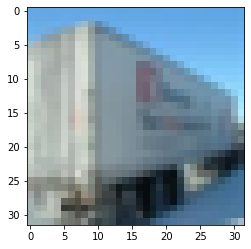

In [ ]:
# print it out as image

import matplotlib.pyplot as plt


plt.imshow(x_train[15])

In [ ]:
# Convert y_train from 2D to 1D 

y_train = y_train.reshape(50000)


In [ ]:
y_train.shape

# expected output: (50000,)

(50000, 10)

In [ ]:
# Convert y_test from 2D to 1D 

y_test = y_test.reshape(10000)


In [ ]:
y_test.shape

# expected output: (10000,)

(10000, 10)

In [ ]:
# Convert class vectors to one hot format

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [ ]:
# Convert data from int to float and normalize it


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

###  Write your code in the cell below to create a CNN model which contains the following types of operations (layers):   

- Conv2D
- Activation
- MaxPooling2D
- Flatten
- Dropout
- Dense

### (optional) You are also encouraged to create multiple models with different activiation functions, different numbers of neurons and layers for performance comparison.

In [ ]:
model = Sequential()

batch_size = 128
input_shape = (32, 32, 3)

#Here is the model I created
#I tried different combinations of activation functioins, nuerons and layers
#This is the one I found to have the best result which close to the following after each execution
#Accuracy score: 0.8134
#Recall score: 0.8134
#Precision score: 0.8144844573504945
#F1 score: 0.8124466419896662

model.add(Conv2D(64, (3, 3), padding='same', input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1028))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation="softmax"))


In [ ]:
# Print model summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
activation (Activation)      (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 128)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)         0

### Write your code in the cell below for compile, earlystopping and fit. Notice that you should use earlystopping

In [ ]:
import time 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

start_time = time.time()
model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=Adam(lr=0.001, decay=1e-6), metrics=['accuracy'])

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

model.fit(x_train, y_train, 
          batch_size=batch_size,
          callbacks = [monitor],
          epochs=100,
          verbose=2,
          validation_data=(x_test, y_test))

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))


Epoch 1/100
391/391 - 4s - loss: 1.5975 - accuracy: 0.4140 - val_loss: 1.1945 - val_accuracy: 0.5756
Epoch 2/100
391/391 - 4s - loss: 1.1728 - accuracy: 0.5822 - val_loss: 0.9956 - val_accuracy: 0.6468
Epoch 3/100
391/391 - 4s - loss: 1.0051 - accuracy: 0.6440 - val_loss: 0.8707 - val_accuracy: 0.7044
Epoch 4/100
391/391 - 4s - loss: 0.9037 - accuracy: 0.6818 - val_loss: 0.7893 - val_accuracy: 0.7242
Epoch 5/100
391/391 - 4s - loss: 0.8343 - accuracy: 0.7084 - val_loss: 0.7741 - val_accuracy: 0.7317
Epoch 6/100
391/391 - 4s - loss: 0.7788 - accuracy: 0.7251 - val_loss: 0.7512 - val_accuracy: 0.7381
Epoch 7/100
391/391 - 4s - loss: 0.7205 - accuracy: 0.7444 - val_loss: 0.6767 - val_accuracy: 0.7633
Epoch 8/100
391/391 - 4s - loss: 0.6859 - accuracy: 0.7585 - val_loss: 0.6807 - val_accuracy: 0.7622
Epoch 9/100
391/391 - 4s - loss: 0.6448 - accuracy: 0.7711 - val_loss: 0.6369 - val_accuracy: 0.7785
Epoch 10/100
391/391 - 4s - loss: 0.6091 - accuracy: 0.7845 - val_loss: 0.6241 - val_accura

### Write your code in the cell below to print out the Precision, Recall,  F1 score, and classification_*report*

### Include your findings in the project report. 

In [ ]:
from sklearn import metrics

y_true = np.argmax(y_test,axis=1)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

accuracy = metrics.accuracy_score(y_true, pred)
print("Accuracy score: {}".format(accuracy))

recall = metrics.recall_score(y_true, pred, average= "weighted")
print("Recall score: {}".format(recall))

precision = metrics.precision_score(y_true, pred, average= "weighted")
print("Precision score: {}".format(precision))

f1 = metrics.f1_score(y_true, pred, average= "weighted")
print("F1 score: {}".format(f1))

print(metrics.classification_report(y_true, pred))

Accuracy score: 0.8127
Recall score: 0.8127
Precision score: 0.8118695039717929
F1 score: 0.8116395250442116
              precision    recall  f1-score   support

           0       0.82      0.83      0.82      1000
           1       0.92      0.90      0.91      1000
           2       0.78      0.70      0.74      1000
           3       0.65      0.64      0.64      1000
           4       0.77      0.80      0.78      1000
           5       0.76      0.71      0.73      1000
           6       0.83      0.89      0.86      1000
           7       0.84      0.86      0.85      1000
           8       0.86      0.93      0.89      1000
           9       0.90      0.88      0.89      1000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000



### Write your code in the cell below to show 3-5 images in the test set as well as their true labels and their labels predicted by your model.

### Include your findings in the project report.

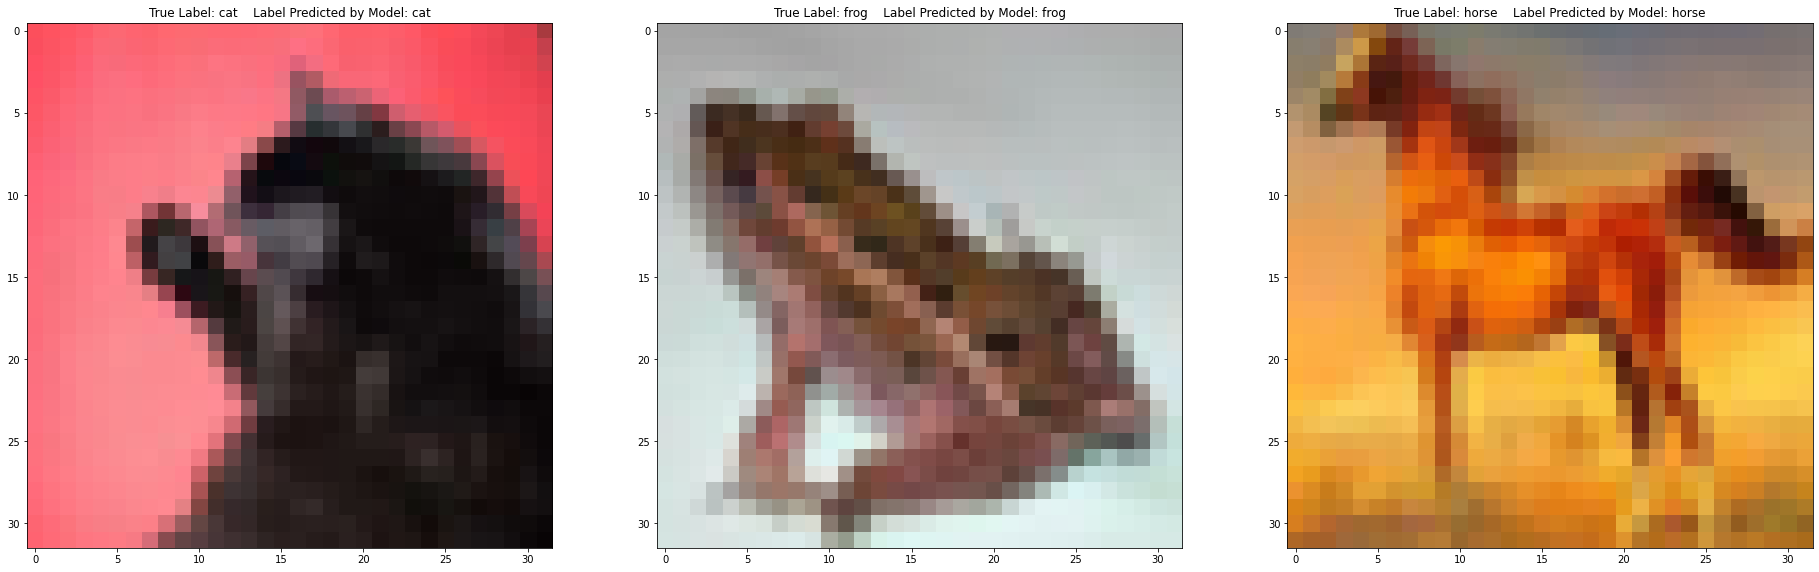

In [ ]:
import matplotlib.pyplot as plt
import cv2

#These are the labels for the cifar10 dataset 
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(32,32))

for i in range(3):
  #Display a random image from test set
  j = np.random.randint(0, x_test.shape[0])

  #it was giving errors so I needed to resize the image to 4 dimensional image
  img = np.reshape(x_test[j], [1, 32, 32, 3])

  #based on code from https://github.com/uchidama/CIFAR10-Prediction-In-Keras/blob/master/keras_cifar10_prediction.ipynb
  plt.subplot(1, 3, i+1)
  plt.imshow(x_test[j])
  plt.title("True Label: "+(labels[np.argmax(y_test[j])]) + "    Label Predicted by Model: "+ (labels[np.argmax(model.predict(img))]))





## Part II:   CNN model with Transfer Learning

In [2]:
#  Load cifar-10 data and split it to training and test
from tensorflow.keras.datasets import cifar10

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

#There are a total of 10 different image categories
num_classes = 10

# We load data again.   The data split between train and test sets:

(x_train, y_train), (x_test, y_test) = cifar10.load_data()


print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)

print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)


print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

170500096/170498071 [==============================] - 4s 0us/step
x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)
50000 train samples
10000 test samples


### Here we would like to use one pre-trained model called VGG16.   For more details on VGG16, please go to https://neurohive.io/en/popular-networks/vgg16/


### VGG16 supports down to 48x48 images as an input. However, the resolution of our images is too low, which is (32, 32) so we need to increase the resolution.   This is called upsampling. 



### Find a way to do upsampling for each image to increase its resolution from 32x32 to 64x64. One option is to use the function resize(), which is provided by scikit-image library (https://scikit-image.org/)


### Things to note: 

#### (1) If you use resize() in scikit-image, that function also normalizes the input image so you may not want to normalize twice.

#### (2) Apply upsampling to x_train and x_test seperately. 

In [3]:
import skimage.transform

new_x_train = []

for img in x_train:
  newImage = skimage.transform.resize(img, (64, 64))
  new_x_train.append(newImage)


# this process may take about a few minutes ....

In [4]:
new_x_train = np.asarray(new_x_train)


In [5]:
new_x_train.shape

(50000, 64, 64, 3)

In [6]:
new_x_test = []

for img in x_test:
  newImage = skimage.transform.resize(img, (64, 64))
  new_x_test.append(newImage) 

# this process may take about a few minutes ....

In [7]:
new_x_test = np.asarray(new_x_test)

In [8]:
new_x_test.shape

(10000, 64, 64, 3)

### Write your code in the cell below to do the following:

- First convert y_train and y_test from 2D to 1D by using reshape() function 
- Next apply one-hot encoding to y_train and y_test by using tf.keras.utils.to_categorical() function

In [9]:
# Convert y_train and y_test from 2D to 1D

y_train = y_train.reshape(50000)
y_test = y_test.reshape(10000)



In [10]:
# double check shape

print(y_train.shape)
print(y_test.shape)


# expected output:  (50000, 10)
# expected output:  (10000, 10)

(50000,)
(10000,)


In [11]:
# Apply one-hot encoding to y_train and y_test
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

###  Load the pre-trained VGG16 model.  Write your code in the cell below to add each layer in VGG16 (excluding the top layers) to your new model.  

In [12]:
from tensorflow.keras.applications.vgg16 import VGG16

from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Flatten, Dense
from keras.models import Model
from keras import models

from tensorflow.keras.layers import Conv2D, MaxPooling2D
import numpy as np

vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))   #  first hidden layer

model = Sequential()

  
# write your code here
for layer in vgg_model.layers:
  model.add(layer)


# print out the model summary
model.summary()


58892288/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
_________________________________________________________

### Write your code in the cell below to freeze the weights in each layer in the new model

In [13]:
for layer in model.layers:
  layer.trainable = False

###  Write your code in the cell below to add some "Dense" layers as top layers.

- Donot forget the output layer
- Choose the right activation fucntion for the output layer

In [14]:
from tensorflow.keras.models import load_model
from keras.layers import *
from keras.models import Sequential
from keras.applications.resnet50 import ResNet50
import keras
import keras.utils
from keras import utils as np_utils
from keras import models
from keras import layers
from keras import backend as K

# model.add(Flatten())
# # Add some "Dense" layers here, including output layer
# model.add(Dense(128, activation='sigmoid'))
# model.add(Flatten())
# model.add(Dense(64, activation='sigmoid'))
# model.add(Flatten())
# model.add(Dropout(0.25))
# model.add(Dense(8, activation='sigmoid'))
# model.add(Dense(num_classes, activation="softmax"))

model.add(Flatten())
# Add some "Dense" layers here, including output layer
model.add(Dense(64, activation='sigmoid'))
model.add(Flatten())
model.add(Dense(128, activation='sigmoid'))
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(128, activation='sigmoid'))
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(num_classes, activation="softmax"))



###  Write your code below for compile and fit. 

### Train your new model. 

### Notice that you should use earlystopping.

In [15]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import time 

start_time = time.time()
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001, decay=1e-6), metrics=['accuracy'])

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

model.fit(new_x_train, y_train, 
          batch_size=128,
          callbacks = [monitor],
          epochs=100,
          verbose=2,
          validation_data=(new_x_test, y_test))

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))


# since we use GPU, the training time for each epoch for the transferred model is about 60 seconds.  
# Let it run for a few epochs. 

Epoch 1/100
391/391 - 20s - loss: 1.9645 - accuracy: 0.3221 - val_loss: 1.6877 - val_accuracy: 0.4662
Epoch 2/100
391/391 - 19s - loss: 1.5436 - accuracy: 0.4995 - val_loss: 1.4229 - val_accuracy: 0.5356
Epoch 3/100
391/391 - 19s - loss: 1.3538 - accuracy: 0.5538 - val_loss: 1.2973 - val_accuracy: 0.5747
Epoch 4/100
391/391 - 19s - loss: 1.2320 - accuracy: 0.5903 - val_loss: 1.2100 - val_accuracy: 0.5985
Epoch 5/100
391/391 - 19s - loss: 1.1452 - accuracy: 0.6218 - val_loss: 1.1420 - val_accuracy: 0.6222
Epoch 6/100
391/391 - 20s - loss: 1.0734 - accuracy: 0.6525 - val_loss: 1.0903 - val_accuracy: 0.6457
Epoch 7/100
391/391 - 19s - loss: 1.0096 - accuracy: 0.6756 - val_loss: 1.0698 - val_accuracy: 0.6463
Epoch 8/100
391/391 - 19s - loss: 0.9535 - accuracy: 0.6935 - val_loss: 1.0286 - val_accuracy: 0.6613
Epoch 9/100
391/391 - 19s - loss: 0.9089 - accuracy: 0.7080 - val_loss: 1.0006 - val_accuracy: 0.6713
Epoch 10/100
391/391 - 19s - loss: 0.8695 - accuracy: 0.7204 - val_loss: 0.9714 - 

### Write your code below to print out the Precision, Recall, F1 score, and classification_report

### Include your findings in the project report.

In [16]:
from sklearn import metrics

y_true = np.argmax(y_test,axis=1)
pred = model.predict(new_x_test)
pred = np.argmax(pred,axis=1)

accuracy = metrics.accuracy_score(y_true, pred)
print("Accuracy score: {}".format(accuracy))

recall = metrics.recall_score(y_true, pred, average= "weighted")
print("Recall score: {}".format(recall))

precision = metrics.precision_score(y_true, pred, average= "weighted")
print("Precision score: {}".format(precision))

f1 = metrics.f1_score(y_true, pred, average= "weighted")
print("F1 score: {}".format(f1))

print(metrics.classification_report(y_true, pred))



Accuracy score: 0.6906
Recall score: 0.6906
Precision score: 0.6934477261513231
F1 score: 0.6904870992906162
              precision    recall  f1-score   support

           0       0.74      0.76      0.75      1000
           1       0.79      0.79      0.79      1000
           2       0.55      0.67      0.60      1000
           3       0.53      0.48      0.50      1000
           4       0.65      0.62      0.64      1000
           5       0.60      0.59      0.59      1000
           6       0.70      0.73      0.71      1000
           7       0.79      0.68      0.73      1000
           8       0.77      0.83      0.80      1000
           9       0.81      0.75      0.78      1000

    accuracy                           0.69     10000
   macro avg       0.69      0.69      0.69     10000
weighted avg       0.69      0.69      0.69     10000



### Write your code in the cell below to show 3-5 images in the test set as well as their true labels and their labels predicted by your model with transfer learning. 

### Include your findings in the project report.

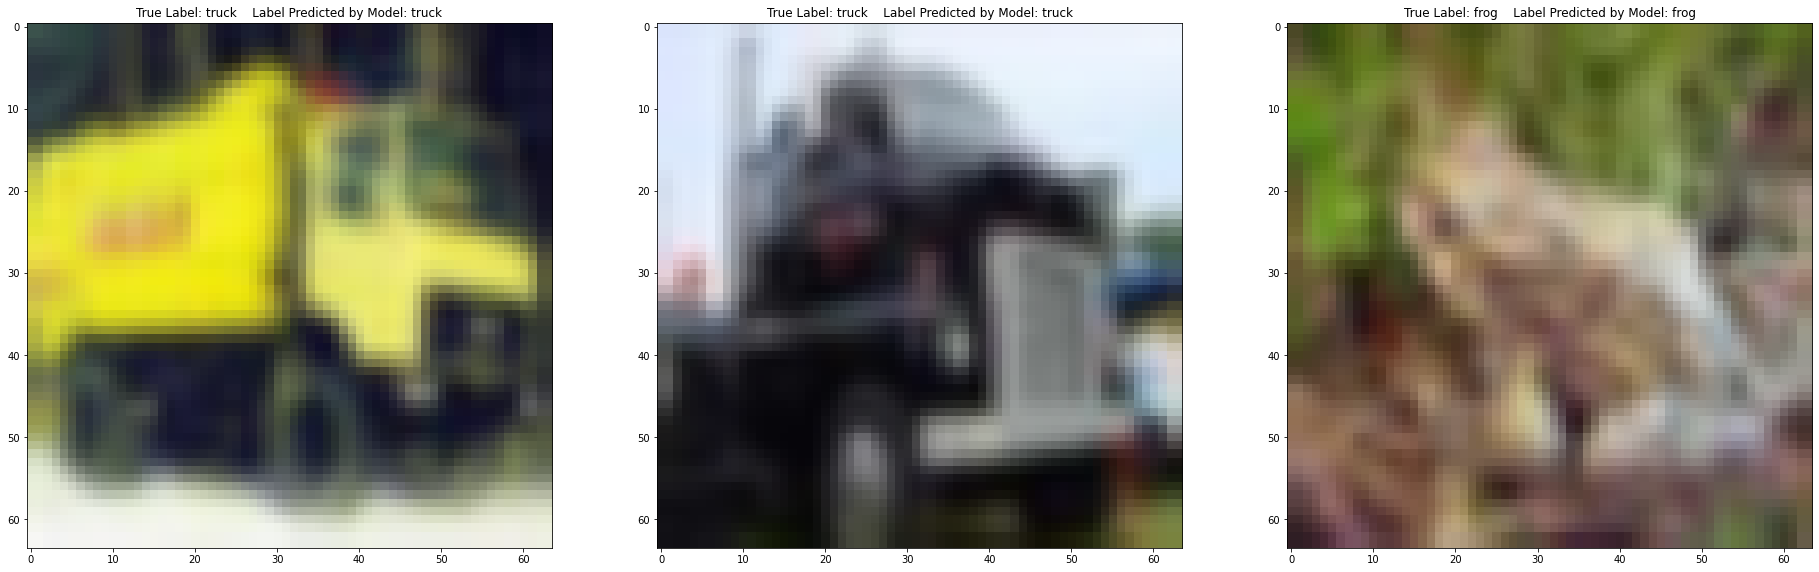

In [17]:
#These are the labels for the cifar10 dataset 
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(32, 32))

for i in range(3):
  #Display a random image from test set
  j = np.random.randint(0, x_test.shape[0])

  #it was giving errors so I needed to resize the image to 4 dimensional image
  img = np.reshape(new_x_test[j], [1, 64, 64, 3])
  
  #based on code from https://github.com/uchidama/CIFAR10-Prediction-In-Keras/blob/master/keras_cifar10_prediction.ipynb
  plt.subplot(1, 3, i+1)
  plt.imshow(new_x_test[j])
  plt.title("True Label: "+(labels[np.argmax(y_test[j])]) + "    Label Predicted by Model: "+ (labels[np.argmax(model.predict(img))]))

